# Week 6: Clustering and Association Mining

### What's on this week
1. [Preparing data for clustering](#prep)
2. [Building your first K-means clustering](#clustering)
3. [Understanding and visualising your clustering model](#viz)
4. [Performing Association mining](#apriori)
5. [Running and understanding results of association mining](#assoc)

---

### Important Changelog:
* (18/09/2017) Made tutorial notes public.

The practical note for this week introduces you to clustering and association rules mining using Python. In addition to the usual data preprocessing, model building and result evaluation/visualisation, I will also introduce you to association mining with `apyori`.

**This tutorial notes is in experimental version. Please give us feedbacks and suggestions on how to make it better. Ask your tutor for any question and clarification.**

## 1. Preparing data for clustering<a name="prep"></a>

For our clustering this week, we will be using the `Census2000` dataset. This dataset contains the postal code-level summary of the 2000 United States Census. It has 7 variables:
* `ID`: Postal code of the region
* `LOCX`: Region longitude
* `LOCY`: Region latitude
* `MEANHHSZ`: Average household size in the region
* `MEDHHINC`: Median household income in the region
* `REGDENS`: Region population density percentile (1=lowest density, 100 = highest density)
* `REGPOP`: Number of people in the region

As usual, load up the data into pandas.

In [1]:
import pandas as pd
df = pd.read_csv('census2000.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33178 entries, 0 to 33177
Data columns (total 7 columns):
ID          33178 non-null object
LocX        33178 non-null float64
LocY        33178 non-null float64
RegDens     32165 non-null float64
RegPop      33178 non-null int64
MedHHInc    33178 non-null int64
MeanHHSz    33178 non-null float64
dtypes: float64(4), int64(2), object(1)
memory usage: 1.8+ MB


Just like week 2, we need to visualise the data to see whether there is data problems within it. We can use `seaborn` and `matplotlib` for that purpose.

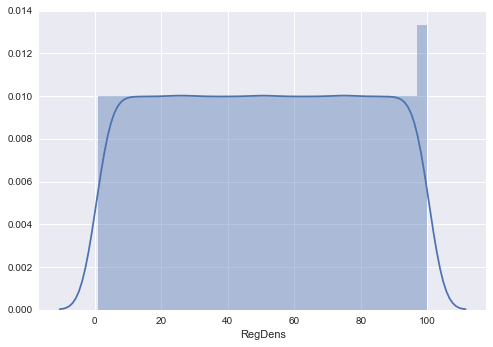

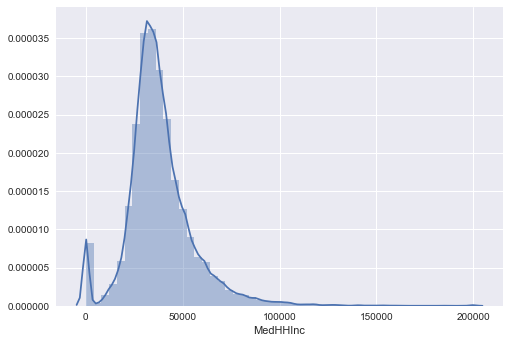

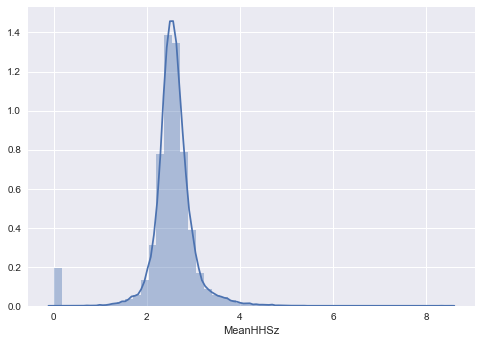

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Distribution of RegDens
regdens_dist = sns.distplot(df['RegDens'].dropna())
plt.show()

# Distribution of MedHHInc
medhhinc_dist = sns.distplot(df['MedHHInc'].dropna())
plt.show()

# Distribution of MeanHHSz
meanhhsz_dist = sns.distplot(df['MeanHHSz'].dropna())

plt.show()

There seems to be some anomalies in `MeanHHSz` data. Let's zoom in closer.

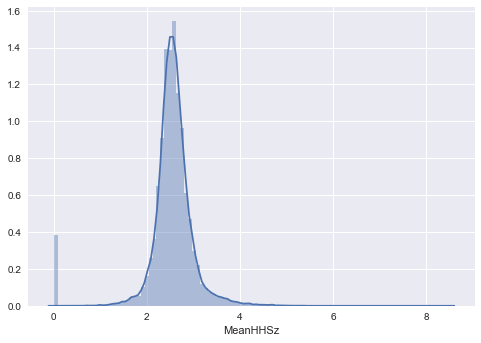

In [3]:
# Distribution of MeanHHSz, with increased number of bins. More bins = more specific distplot.
meanhhsz_dist = sns.distplot(df['MeanHHSz'].dropna(), bins=100)
plt.show()

It becomes apparent that many of the records are valued at zero, and it seems very unlikely for an household to have zero members. This points out to a data problem. I wonder how does these errorneous values affect other variables. We could explore this relation using FaceTGrid.

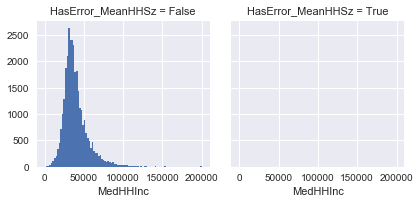

In [4]:
import numpy as np
df['HasError_MeanHHSz'] = df['MeanHHSz'] < 0.1

g = sns.FacetGrid(df, col='HasError_MeanHHSz')
g = g.map(plt.hist, 'MedHHInc', bins=100)

plt.show()

FacetGrid shows that errorneous data in `MeanHHSz` are correlated with errorneous data in other features. We can see that in `MedHHInc` here, most records with `MeanHHSz` also has way lower than normal values. This serves as a good reason to eliminate all rows with errorneous `MeanHHSz`.

In [5]:
# before
print("Before dropping errorneous rows", len(df))

# a very easy way to drop rows with MeanHHSz values below 0.1
df = df[df['MeanHHSz'] >= 0.1]

# after
print("After dropping errorneous rows", len(df))

Before dropping errorneous rows 33178
After dropping errorneous rows 32097


## 2. Building your first K-means clustering<a name="clustering"></a>

Now we are set to build our clustering model. Just before we jump in the models, let's determine the objective of this clustering process first. There are a number of good grouping objectives that we can apply in this dataset. We could cluster them based on location (`LocX` and `LocY`), demographic characteristics or both. For this tutorial, I would like to focus on demographic characteristics.

Thus, we will use `MedHHInc`, `MeanHHSz` and `RegDens` and drop the rest of the features. You might wonder why `RegPop` is discarded. First, it is a data about number of people in an area, which is already covered by `RegDens`. Secondly, `RegPop` is highly influenced by the actual size of the region, an information we do not have. In comparing regions using their demographic information, it is more accurate to use `RegDens`.

In [6]:
from sklearn.preprocessing import StandardScaler
df2 = df[['MedHHInc', 'MeanHHSz', 'RegDens']]
scaler = StandardScaler()

X = df2.as_matrix()
X = scaler.fit_transform(X)

Import our K-Means clustering from sklearn. Build a K-means cluster with K=3 and print out its `inertia` (sum of distances of samples to their closest cluster center/centroid). Remember, in clustering, we want to minimize the intra-cluster distance while maximizing the inter-cluster distances.

In [7]:
from sklearn.cluster import KMeans

# set the random state. different random state seeds might result in different centroids locations
model = KMeans(n_clusters=3, random_state=42)
model.fit(X)

# sum of intra-cluster distances
print("Sum of intra-cluster distance:", model.inertia_)

print("Centroid locations:")
for centroid in model.cluster_centers_:
    print(centroid)

Sum of intra-cluster distance: 52549.9072954
Centroid locations:
[-0.41275655 -0.08490495 -0.88299186]
[ 1.32604863  0.91415041  0.7568173 ]
[-0.17389581 -0.4089853   0.83829636]


Higher K = more centroids = better intra-cluster distance = finer grained clusters = slower training.

In [8]:
# set a different n_clusters
model = KMeans(n_clusters=8, random_state=42)
model.fit(X)

# sum of intra-cluster distances
print("Sum of intra-cluster distance:", model.inertia_)

print("Centroid locations:")
for centroid in model.cluster_centers_:
    print(centroid)

Sum of intra-cluster distance: 27888.0052791
Centroid locations:
[-0.24637461  0.49506801 -0.94539867]
[-0.19894362 -1.04645703  1.14580103]
[-0.27198044 -0.15249401 -0.00368778]
[ 3.41626444  0.55361654  0.97391772]
[-0.43350059  0.69262846  1.1340166 ]
[ 1.1143193   0.3109762   0.77048989]
[-0.31455058  3.22918414  0.14403039]
[-0.5753844  -0.70480196 -1.19325666]


### Determining K stuffs.

In [9]:
# from tqdm import tqdm_notebook
# cluster_costs = []

# for k in tqdm_notebook(range(2, 21, 1)):
#     model = KMeans(n_clusters=k, random_state=42, n_jobs=-1)
#     model.fit(X)
    
#     cluster_costs.append(model.inertia_)

In [10]:
# plt.plot(range(2,21,1), cluster_costs, marker='x')
# # plt.scatter(range(2,23, 2), cluster_costs)
# plt.show()

## 3. Understanding and Visualising Your Clustering Model

We will dive deeper into our clustering model. A great way to start understanding our clustering results is to visualise the value distribution in our dataset. We have done this in a very limited way by printing the values of centroids.

To gain an even better view on how the clusters are spread out in the dataset, we could use seaborn's pairplot. We will need cluster IDs assigned to each record first, then call the pairplot.

Cluster membership
2    7369
7    6072
0    5296
5    4897
1    3987
4    2468
3    1030
6     978
Name: Cluster_ID, dtype: int64


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


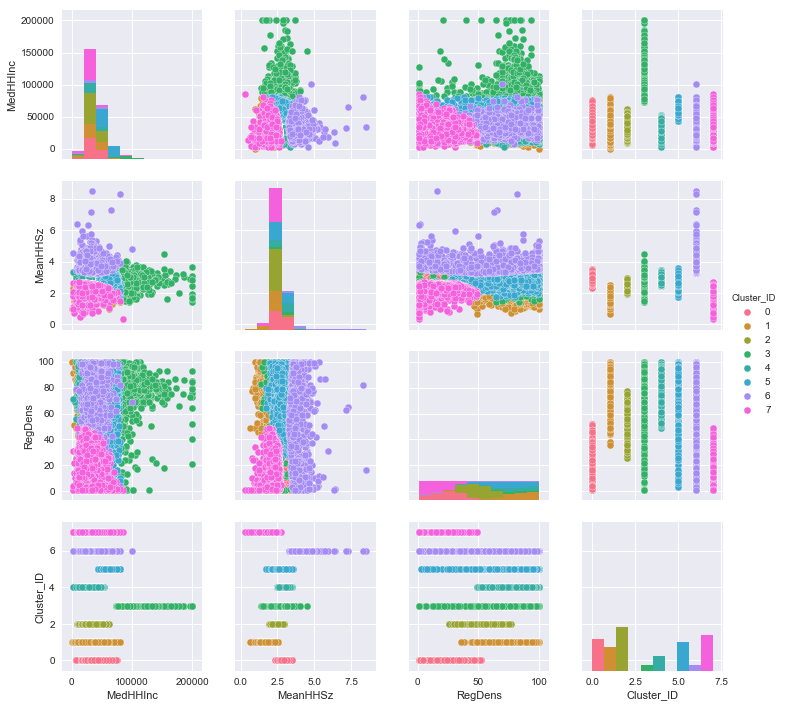

In [11]:
# assign cluster ID to each record in X. Ignore the warning, does not apply to our case here
y = model.predict(X)
df2['Cluster_ID'] = y

print("Cluster membership")
print(df2['Cluster_ID'].value_counts())

cluster_g = sns.pairplot(df2, hue='Cluster_ID')
plt.show()

The pairplot shows us how different cluster members have different value distribution on different variables. Here is how to read it:
1. Take `MeanHHSz` distribution for example (second row, fourth column). Cluster 1 generally covers regions with average large households, while cluster 0 and 2 covers the smaller ones.
2. Look at `MeanHHSz` and `RegDens` plot (second row, third column) and we could see the difference between regions in cluster 0 and 2. Cluster 0 covers less densely populated regions with smaller households, while cluster 2 covers more crowded regions and still small families.
3. For `MedHHInc` (first row, second column), pairplot shows that cluster 1 covering regions with higher median household.

Thus, we could profile the clusters as follow:
* Cluster 0: Sparse populated regions with smaller, low earning households.
* Cluster 1: Regions with large households and higher earnings.
* Cluster 2: Dense populated regions with smaller, low earning households.

While this visualisation is useful and you could derive the cluster profiles, it gets a bit confusing once you have more clusters. Take the following clustering model with `k` = 8.

In [12]:
# set a different n_clusters
model = KMeans(n_clusters=8, random_state=42)
model.fit(X)

# sum of intra-cluster distances
print("Sum of intra-cluster distance:", model.inertia_)

print("Centroid locations:")
for centroid in model.cluster_centers_:
    print(centroid)

Sum of intra-cluster distance: 27888.0052791
Centroid locations:
[-0.24637461  0.49506801 -0.94539867]
[-0.19894362 -1.04645703  1.14580103]
[-0.27198044 -0.15249401 -0.00368778]
[ 3.41626444  0.55361654  0.97391772]
[-0.43350059  0.69262846  1.1340166 ]
[ 1.1143193   0.3109762   0.77048989]
[-0.31455058  3.22918414  0.14403039]
[-0.5753844  -0.70480196 -1.19325666]


Cluster membership
2    7369
7    6072
0    5296
5    4897
1    3987
4    2468
3    1030
6     978
Name: Cluster_ID, dtype: int64


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


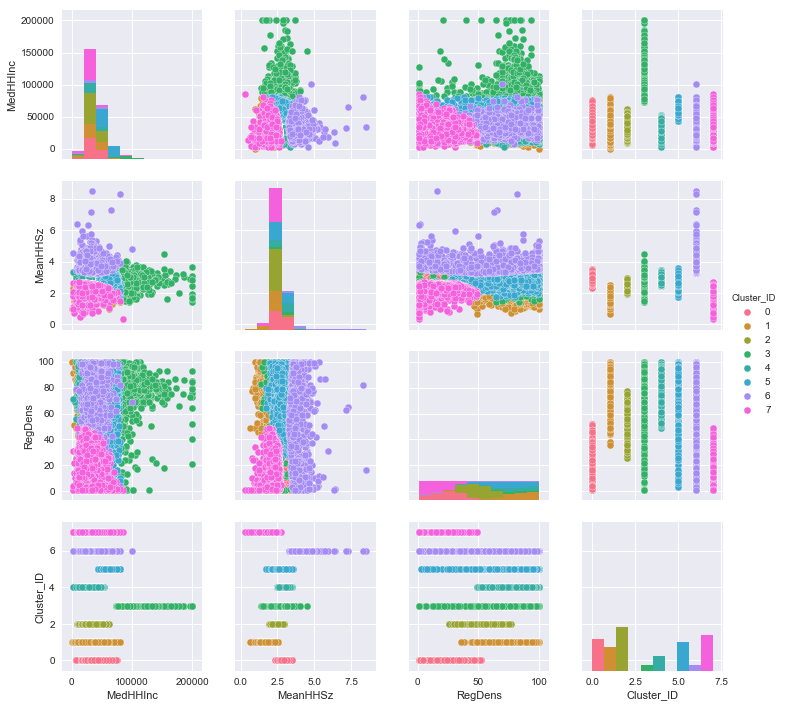

In [13]:
y = model.predict(X)
df2['Cluster_ID'] = y

print("Cluster membership")
print(df2['Cluster_ID'].value_counts())

cluster_g = sns.pairplot(df2, hue='Cluster_ID')
plt.show()

Thus, another way to profile our segments is to plot their respective variable distributions against the distribution from all data. We can do with distplot in the following code:

Distribution for cluster 0


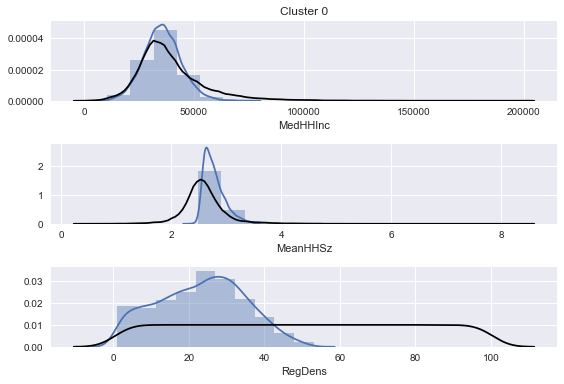

Distribution for cluster 1


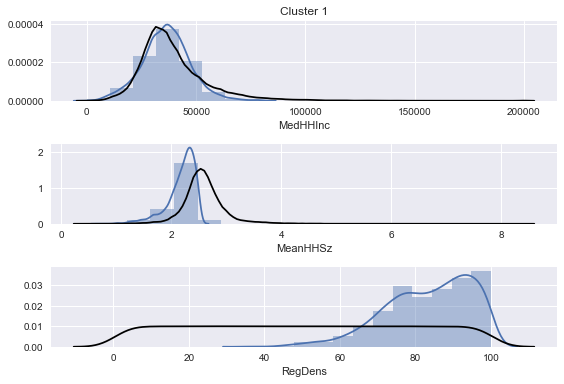

In [14]:
# prepare the column and bin size. Increase bin size to be more specific, but 20 is more than enough
cols = ['MedHHInc', 'MeanHHSz', 'RegDens']
n_bins = 20

# inspecting cluster 0
print("Distribution for cluster 0")
cluster_to_inspect = 0

# create subplots
fig, ax = plt.subplots(nrows=3)
ax[0].set_title("Cluster {}".format(cluster_to_inspect))

for j, col in enumerate(cols):
    # create the bins
    bins = np.linspace(min(df2[col]), max(df2[col]), 20)
    # plot distribution of the cluster using histogram
    sns.distplot(df2[df2['Cluster_ID'] == cluster_to_inspect][col], bins=bins, ax=ax[j], norm_hist=True)
    # plot the normal distribution with a black line
    sns.distplot(df2[col], bins=bins, ax=ax[j], hist=False, color="k")

plt.tight_layout()
plt.show()

# inspecting cluster 1
print("Distribution for cluster 1")
cluster_to_inspect = 1

# again, subplots
fig, ax = plt.subplots(nrows=3)
ax[0].set_title("Cluster {}".format(cluster_to_inspect))

for j, col in enumerate(cols):
    # create the bins
    bins = np.linspace(min(df2[col]), max(df2[col]), 20)
    # plot distribution of the cluster using histogram
    sns.distplot(df2[df2['Cluster_ID'] == cluster_to_inspect][col], bins=bins, ax=ax[j], norm_hist=True)
    # plot the normal distribution with a black line
    sns.distplot(df2[col], bins=bins, ax=ax[j], hist=False, color="k")
    
plt.tight_layout()
plt.show()

(Cluster result are typically the same, but the cluster IDs change all the time even with similar random seed).

Here, we plot the distributions of cluster 0 and cluster 1 against the normal distribution from all data. We could see the difference between these clusters as follow:
1. Cluster 0 covers regions with low median household income, small average household size and are less dense populated.
2. Cluster 1 covers regions with high median household income, large average household size and are very densely populated.

## 4. Performing Association Mining

In `bank.csv` dataset, a bank's marketing department is interested in examining associations between various retail banking services used by almost 8,000 customers. Marketing would like to determining both typical and atypical service combinations as well as the order in which the services were first used.

These requirements suggests association mining - both a market bastket analysis and a sequence analysis. The data for this problem is usually consisted of two variables, a transaction and an item. For each transaction, there is a list of items. Typically, a transaction is a single customer purchase, and the items are the things that were bought in that transcation. An association rule is a statement of the form (item set A) => (item set B).

Unfortunately, `sklearn` does not provide any implementation of Apriori algorithm to be used in association mining. Do not worry though, one of the strengths of Python is there is a ton of libraries to use for virtually all kinds of task. We will be using `apyori` library for this task, which can be installed with command:

```bash
pip install apyori
```

Once your installation is done, we need to perform some data preprocessing on the bank dataset. Firstly, load the data set using pandas.

In [16]:
# load the bank transaction dataset
df = pd.read_csv('bank.csv')

# info and the first 10 transactions
print(df.info())
print(df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32367 entries, 0 to 32366
Data columns (total 3 columns):
ACCOUNT    32367 non-null int64
SERVICE    32367 non-null object
VISIT      32367 non-null int64
dtypes: int64(2), object(1)
memory usage: 758.7+ KB
None
   ACCOUNT SERVICE  VISIT
0   500026   CKING      1
1   500026     SVG      2
2   500026     ATM      3
3   500026     ATM      4
4   500075   CKING      1
5   500075    MMDA      2
6   500075     SVG      3
7   500075     ATM      4
8   500075   TRUST      5
9   500075   TRUST      6


The BANK data set contains service information for nearly 8,000 customers. There are three variables in the data set:
1. ACCOUNT: Account number, nominal
2. SERVICE: Type of service, nominal
3. VISIT: Order of product purchased, ordinal

The BANK data set has over 32,000 rows. Each row of the data set represents a customer-service combination. Therefore, a single customer can have multiple rows in the data set, and each row represents one of the products he or she owns. The median number of products per customer is three. The 13 products are represented in the data set using the following abbreviations:
* ATM - automated teller machine debit card
* AUTO automobile installment loan
* CCRD credit card
* CD certificate of deposit
* CKCRD check/debit card
* CKING checking account
* HMEQLC home equity line of credit
* IRA individual retirement account
* MMDA money market deposit account
* MTG mortgage
* PLOAN personal/consumer installment loan
* SVG saving account
* TRUST personal trust account

As we are looking to generate association rules from items purchased by each account holder, we need to group our accounts and then generate list of all services purchased.

In [17]:
# group by account, then list all services
transactions = df.groupby(['ACCOUNT'])['SERVICE'].apply(list)

print(transactions.head(5))

ACCOUNT
500026                   [CKING, SVG, ATM, ATM]
500075    [CKING, MMDA, SVG, ATM, TRUST, TRUST]
500129              [CKING, SVG, IRA, ATM, ATM]
500256               [CKING, SVG, CKCRD, CKCRD]
500341               [CKING, SVG, CKCRD, CKCRD]
Name: SERVICE, dtype: object


Now that the `transactions` table contains all services purchased by each account number, we are ready to build our association rules. `apyori`'s `apriori` function accepts a number of arguments, mainly:
1. `transactions`: list of list of items in transactions (eg. [['A', 'B'], ['B', 'C']]).
2. `min_support`: Minimum support of relations in float percentage. Default 0.1.
3. `min_confidence`: Minimum confidence of relations in float percentage. Default 0.0.
4. `min_lift`: Minimum lift of relations in float percentage. Default 0.0.
5. `max_length`: Max length of the relations. Default None.

We will run our `apyori` model with our transactions and min_support of 0.05.

In [19]:
from apyori import apriori

# type cast the transactions from pandas into normal list format and run apriori
transaction_list = list(transactions)
results = list(apriori(transaction_list, min_support=0.05))

# print first 5 rules
print(results[:5])

[RelationRecord(items=frozenset({'ATM'}), support=0.3845576273307471, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'ATM'}), confidence=0.3845576273307471, lift=1.0)]), RelationRecord(items=frozenset({'AUTO'}), support=0.09285446126892755, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'AUTO'}), confidence=0.09285446126892755, lift=1.0)]), RelationRecord(items=frozenset({'CCRD'}), support=0.154799149042673, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'CCRD'}), confidence=0.154799149042673, lift=1.0)]), RelationRecord(items=frozenset({'CD'}), support=0.24527593542735576, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'CD'}), confidence=0.24527593542735576, lift=1.0)]), RelationRecord(items=frozenset({'CKCRD'}), support=0.11300212739331748, ordered_statistics=[OrderedStatistic(items_base=frozenset(), items_add=frozenset({'CKCRD'}), confidence=0.1

Now the output might look very weird, and that is fine. I have provided the following function to help you printing it out. I won't explain how it works and it is not essential for your learning objective, but I have included some comments to help you out.

In [26]:
def convert_apriori_results_to_pandas_df(results):
    rules = []
    
    for rule_set in results:
        for rule in rule_set.ordered_statistics:
            rules.append([','.join(rule.items_base), ','.join(rule.items_add), # items_base = left side of rules, items_add = right side
                         rule_set.support, rule.confidence, rule.lift]) # support, confidence and lift for respective rules
    
    return pd.DataFrame(rules, columns=['Left_side', 'Right_side', 'Support', 'Confidence', 'Lift']) # typecast it to pandas df

result_df = convert_apriori_results_to_pandas_df(results)

print(result_df.head(20))

   Left_side Right_side   Support  Confidence      Lift
0                   ATM  0.384558    0.384558  1.000000
1                  AUTO  0.092854    0.092854  1.000000
2                  CCRD  0.154799    0.154799  1.000000
3                    CD  0.245276    0.245276  1.000000
4                 CKCRD  0.113002    0.113002  1.000000
5                 CKING  0.857840    0.857840  1.000000
6                HMEQLC  0.164685    0.164685  1.000000
7                   IRA  0.108372    0.108372  1.000000
8                  MMDA  0.174446    0.174446  1.000000
9                   MTG  0.074334    0.074334  1.000000
10                  SVG  0.618696    0.618696  1.000000
11       ATM         CD  0.071581    0.186137  0.758889
12        CD        ATM  0.071581    0.291837  0.758889
13       ATM      CKING  0.361907    0.941100  1.097058
14     CKING        ATM  0.361907    0.421882  1.097058
15       ATM     HMEQLC  0.085346    0.221933  1.347619
16    HMEQLC        ATM  0.085346    0.518237  1

The table contains statistics of support, condence and lift for each of the rules.

Consider the rule A ⇒ B. Recall the following:
* Support of A ⇒ B is the probability that a customer has both A and B.
* Confidence of A ⇒ B is the probability that a customer has B given that the customer has A.
* Expected confidence (not shown here) of A ⇒ B is the probability that a customer has B.
* Lift of A ⇒ B is a measure of strength of the association. If Lift=2 for the rule A=>B, then a customer having A is twice as likely to have B than a customer chosen at random. Lift is the confidence divided by expected confidence.

In a typical setting, we would like to view the rules by lift. Sort the rules using code below:

In [29]:
result_df = result_df.sort_values(by='Lift', ascending=False)
print(result_df.head(10))

            Left_side Right_side   Support  Confidence      Lift
79         CKING,CCRD      CKCRD  0.055813    0.375737  3.325045
25               CCRD      CKCRD  0.055813    0.360550  3.190645
80        CKING,CKCRD       CCRD  0.055813    0.493909  3.190645
26              CKCRD       CCRD  0.055813    0.493909  3.190645
104     CKING,SVG,ATM     HMEQLC  0.060944    0.245217  1.489001
73            SVG,ATM     HMEQLC  0.060944    0.237214  1.440407
63          CKING,ATM     HMEQLC  0.085346    0.235823  1.431961
74         SVG,HMEQLC        ATM  0.060944    0.546577  1.421313
106  CKING,SVG,HMEQLC        ATM  0.060944    0.546577  1.421313
65       CKING,HMEQLC        ATM  0.085346    0.518237  1.347619


The highest lift rule is *checking*, and *credit card* implies *check card*. This is not surprising given that many check cards include credit card logos.

## End Notes and Next Week

This week, we learned how to build, tune and explore clustering models. We also visualisation technique to help us explain the cluster/segment profiles produced by the model. In addition, we also built association mining model using `apyori` library and explored the rules produced by it.

Next week, we will learn about my favourite field, text mining. It is gonna be fun, boys and girls!